In [61]:
import matplotlib.pyplot as pl
%matplotlib inline
import numpy as np
import everest
import celerite
from celerite import terms
from scipy.linalg import cho_factor, cho_solve
from scipy.optimize import minimize
from itertools import combinations_with_replacement as multichoose
import pysyzygy as ps

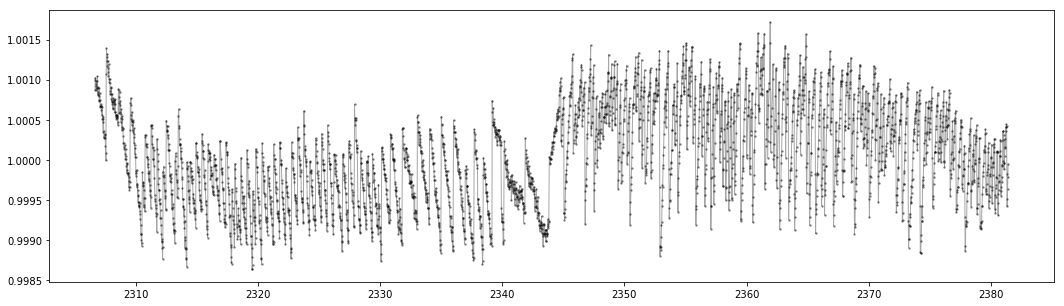

In [111]:
# Download the data
star = everest.Everest(211836369, quiet = True)
#star = everest.Everest(210517342, quiet = True)

# Remove outliers, get a nice subset of the data
cut = slice(None)
t = star.apply_mask(star.time)[cut]
F = star.apply_mask(star.fpix)[cut]
fdet = star.apply_mask(star.flux)[cut]

# Find the outliers
fsap = np.sum(F, axis = 1)
f = everest.math.SavGol(fsap)
M = np.nanmedian(f)
MAD = 1.4826 * np.nanmedian(np.abs(f - M))
out = (f > M + 5 * MAD) | (f < M - 5 * MAD)

# Apply the cut
t = np.array(t[~out])
fsap = np.array(fsap[~out])
F = np.array(F[~out,:])
fdet = np.array(fdet[~out])

# Normalize
med = np.median(fsap)
fsap /= med
F /= med
fdet /= med

# Plot
fig = pl.figure(figsize = (18,5))
pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);

In [105]:
# Celerite kernel
yerr = np.nanmedian(np.abs(np.diff(fsap)))
kernel = terms.SHOTerm(log_S0 = np.log(np.var(fsap)), log_Q = -0.5 * np.log(2), 
                       log_omega0 = np.log(2 * np.pi / 8.),
                       bounds = dict(log_S0 = (-15,5), log_omega0 = np.log(2 * np.pi / np.array([15., 1.]))))
kernel.freeze_parameter('log_Q')
kernel += terms.JitterTerm(log_sigma = np.log(yerr))
gp = celerite.GP(kernel = kernel, mean = 1.)

In [106]:
# Get 2nd order design matrix w/ regularization
# and a reduced basis size
logL1 = np.log(10)
logL2 = np.log(10)
A1 = F / fsap.reshape(-1, 1)
A2 = np.product(list(multichoose(A1.T, 2)), axis = 1).T
A = np.hstack((A1, A2))
L = np.concatenate((np.exp(logL1) * np.ones(A1.shape[1]),
                    np.exp(logL2) * np.ones(A2.shape[1])))

In [123]:
# Do PCA stuff
U, S, V = np.linalg.svd(A2 - np.mean(A2, axis = 0), full_matrices=True)
print(U.shape, S.shape, V.shape)

(3505, 3505) (528,) (528, 528)


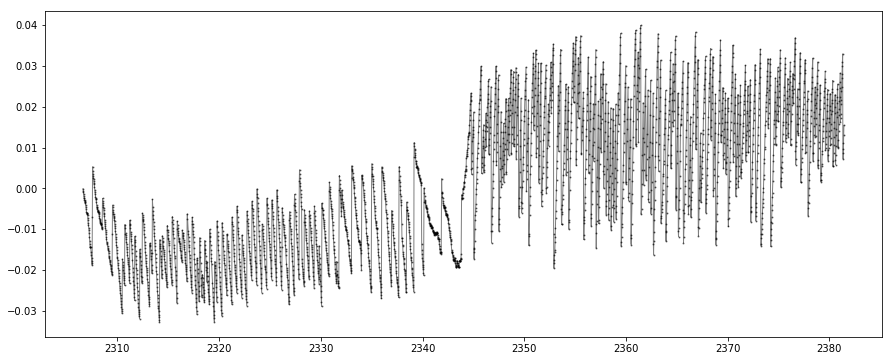

In [124]:
fig = pl.figure(figsize=(15,6))
pl.plot(t, U[:,0], 'k.-', alpha = 0.5, ms = 2, lw = 1);

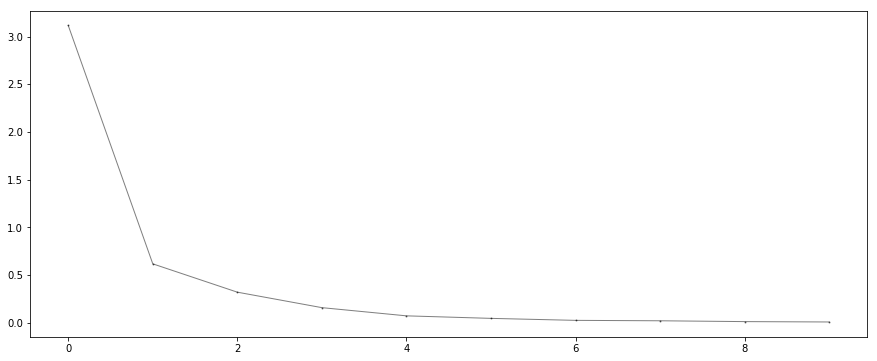

In [127]:
fig = pl.figure(figsize=(15,6))
pl.plot(S[:10], 'k.-', alpha = 0.5, ms = 2, lw = 1);

In [133]:
# Reduce the number of regressors
def GetA(smin = 0.1):
    
    global A, A1tiny, A2tiny
    
    # 1st order
    U, S, V = np.linalg.svd(A1 - np.mean(A1, axis = 0), full_matrices=True)
    n1 = np.argmax(S / S[0] < smin)
    A1tiny = U[:,:n1]
    
    # 2nd order
    U, S, V = np.linalg.svd(A2 - np.mean(A2, axis = 0), full_matrices=True)
    n2 = np.argmax(S / S[0] < smin)
    A2tiny = U[:,:n2]
    
    # Compute A
    A = np.hstack((A1tiny, A2tiny))

In [134]:
# Get the prediction
def get_weights(logL1, logL2):
    L = np.concatenate((np.exp(logL1) * np.ones(A1tiny.shape[1]),
                        np.exp(logL2) * np.ones(A2tiny.shape[1])))
    alpha = np.dot(A.T, gp.apply_inverse(fsap - gp.mean.value)[:, 0])
    ATKinvA = np.dot(A.T, gp.apply_inverse(A))
    S = np.array(ATKinvA)
    S[np.diag_indices_from(S)] += 1. / L
    factor = cho_factor(S, overwrite_a=True)
    alpha -= np.dot(ATKinvA, cho_solve(factor, alpha))
    return L * alpha

def get_pred(logL1, logL2):
    w = get_weights(logL1, logL2)
    return np.dot(A, w)

# Compute the likelihood
def NegLnLike(x, **kwargs):
    
    # Set params
    logL1, logL2 = x[-2:]
    L = np.concatenate((np.exp(logL1) * np.ones(A1tiny.shape[1]),
                        np.exp(logL2) * np.ones(A2tiny.shape[1])))
    gp.set_parameter_vector(x[:-2])

    # Do stuff
    r = fsap - gp.mean.value
    alpha = gp.apply_inverse(r)[:, 0]
    value = np.dot(r, alpha)
    ATalpha = np.dot(A.T, alpha)
    S = np.dot(A.T, gp.apply_inverse(A))
    S[np.diag_indices_from(S)] += 1.0 / L
    factor = cho_factor(S, overwrite_a=True)
    value -= np.dot(ATalpha, cho_solve(factor, ATalpha))
   
    # Penalty terms
    log_det = 2*np.sum(np.log(np.diag(factor[0])))
    log_det += np.sum(np.log(L))
    log_det += gp.solver.log_determinant()
   
    return 0.5 * (value + log_det)

In [142]:
# Minimize!
from tqdm import tqdm
smin = np.logspace(0, -7, 50)
cdpp = np.zeros_like(smin)
nreg1 = np.zeros_like(smin)
nreg2 = np.zeros_like(smin)
for i, s in tqdm(enumerate(smin), total = 50):
    GetA(s)
    gp.compute(t)
    x0 = np.append(gp.get_parameter_vector(), [logL1, logL2])
    bounds = gp.get_parameter_bounds() + [(None, None), (None, None)]
    res = minimize(NegLnLike, x0, bounds = bounds)
    gp.set_parameter_vector(res.x[:-2])
    pred = get_pred(*res.x[-2:])
    cdpp[i] = everest.k2.CDPP(fsap - pred)
    nreg1[i] = A1tiny.shape[1]
    nreg2[i] = A2tiny.shape[1]

100%|██████████| 50/50 [03:06<00:00,  7.86s/it]


array([  1.,   1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   4.,   4.,
         4.,   5.,   5.,   5.,   6.,   7.,   8.,   8.,   9.,   9.,   9.,
         9.,  11.,  11.,  12.,  13.,  15.,  19.,  29.,  31.,  31.,  31.,
        31.,  31.,  31.,  31.,  31.,  31.,  31.,  31.,  31.,  31.,  31.,
        31.,  31.,  31.,  31.,  31.,  31.])

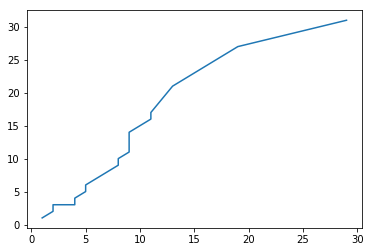

In [151]:
pl.plot(nreg1[:30], nreg2[:30])
nreg1

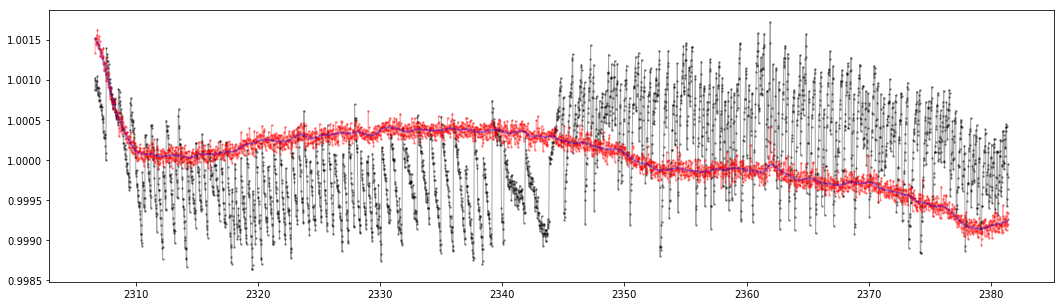

In [131]:
# Plot the results
fig = pl.figure(figsize = (18,5))
pl.plot(t, fsap, 'k.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, fsap - pred, 'r.-', alpha = 0.35, ms = 3, lw = 1);
pl.plot(t, gp.predict(fsap - pred, return_cov = False), 'b-', alpha = 0.35, ms = 3, lw = 2);